# Document Type Classification 2조

### Contents
- Import Library & Loading Data
- EDA
- Data Preprocessing
- Define Functions
- Modeling
- Train Model
- Result
- Save File

## 1. Import Library

In [3]:
import os
import time
import random
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam, AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import augraphy
from sklearn.model_selection import KFold
from glob import glob
from matplotlib.gridspec import GridSpec
from timm import create_model
#import wandb

In [80]:
import sys
!{sys.executable} -m pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 1.2 MB/s eta 0:00:0000:0100:01m


In [4]:
# 랜덤하게 seed 설정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [5]:
#load data
train_df = pd.read_csv("/Users/choesumin/Documents/upstage/data/train.csv")
meta_df = pd.read_csv("/Users/choesumin/Documents/upstage/data/meta.csv")
image_dir = "/Users/choesumin/Documents/upstage/data/train"

In [7]:
#클래스별 이미 파일명과 클래스명 매핑
train_df = train_df.merge(meta_df, on='target')
class_names = train_df['class_name'].unique()

In [7]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df["class_name"])

In [54]:
def create_label_to_index(labels):
    unique_labels = set(labels)
    return {label: idx for idx, label in enumerate(unique_labels)}

## 2. EDA

#### <span style="color:slateblue">problem 1 </span>: 클래스별 데이터 불균형 
에폭 수를 늘리면 늘릴수록 차이는 점점 더 벌어 점차 적은 클래스를 무시하는 방향으로 학습됨(점차 가중치 줄어들기 때문)

In [21]:
#데이터 균형 확인 함수
def show_data_balance(df, label_column='class_name'):
    class_distribution = df[label_column].value_counts()
    print(class_distribution)
    plt.figure(figsize=(10, 6))
    class_distribution.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

class_name
vehicle_registration_plate                               100
pharmaceutical_receipt                                   100
application_for_payment_of_pregnancy_medical_expenses    100
account_number                                           100
confirmation_of_admission_and_discharge                  100
prescription                                             100
national_id_card                                         100
car_dashboard                                            100
medical_outpatient_certificate                           100
payment_confirmation                                     100
resume                                                   100
passport                                                 100
statement_of_opinion                                     100
vehicle_registration_certificate                         100
driver_lisence                                           100
diagnosis                                                100
medical_bill_

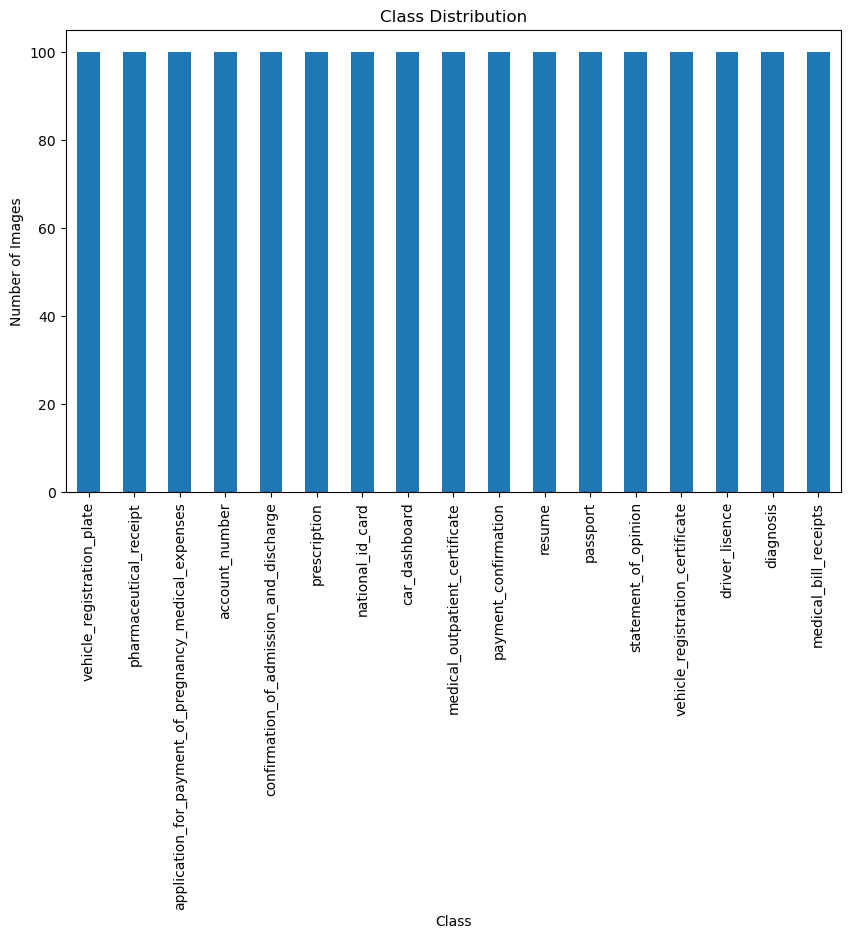

In [25]:
show_data_balance(train_df)

## 3. Data PreProcessing

#### 데이터프레임에 존재하지 않는 이미지 파일 행 제거

In [14]:
# Missing images 제거 함수
def remove_missing_images(df, image_dir):
    available_data = []
    missing_files = []

    for _, row in df.iterrows():
        img_id = row['ID']
        img_path = os.path.join(image_dir, img_id)
        if os.path.exists(img_path):
            available_data.append(row)
        else:
            missing_files.append(img_id)

    # 누락된 파일 로그 출력
    if missing_files:
        print(f"Warning: {len(missing_files)} images not found and will be removed from the dataset.")
        print(f"Missing files: {missing_files}")

    # 누락된 파일을 제외한 DataFrame 반환
    return pd.DataFrame(available_data)

In [15]:
train_df = remove_missing_images(train_df, image_dir)
val_df = remove_missing_images(val_df, image_dir)

#### <span style="color:slateblue">solution 1 </span> [트레이닝 데이터셋 클래스별 데이터 불균형 해소] : oversampling - 수치형 데이터에 적합 


#### <span style="color:slateblue">solution 1 </span> [트레이닝 데이터셋 클래스별 데이터 불균형 해소] : Albumentations


In [18]:
#증강 파이프라인 설정
augmentation_pipeline = A.Compose([
    A.Resize(128, 128),  # 크기 조정 추가
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Blur(blur_limit=3, p=0.1),
    ToTensorV2()
])

# 기본 변환 설정 (검증 또는 테스트 데이터에 사용)
basic_transform = A.Compose([
    A.Resize(128, 128),
    ToTensorV2()
])

In [17]:
#Augmentation - Albumentation
def get_albumentations_pipeline():
    return A.Compose([
        A.Resize(128, 128),
        A.OneOf([
            A.Transpose(p=0.3),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3)
        ], p=0.5),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.3),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3)
        ], p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        ToTensorV2()
    ])

In [20]:
# Augraphy
def get_augraphy_augmentations():
    return aug.Compose([
        aug.OneOf([
            aug.InkBleed(intensity_range=(0.1, 0.3), p=0.5)
        ], p=0.5),
        aug.OneOf([
            aug.LightingGradient(lightness_range=(0.5, 1.0), p=0.5),
            aug.LowLightNoise(p=0.3)
        ], p=0.5),
        aug.OneOf([
            aug.ReflectedLight(p=0.4),
            aug.ShadowCast(shadow_intensity_range=(0.3, 0.6), p=0.4)
        ], p=0.5)
    ])

In [21]:
# mixup 함수 - 크기와 채널을 일관되게 처리
def mixup(image1, image2, alpha=0.4):
    # 이미지가 numpy 배열인지 확인하고 변환
    if not isinstance(image1, np.ndarray):
        image1 = np.array(image1)
    if not isinstance(image2, np.ndarray):
        image2 = np.array(image2)
        
    # 두 이미지 크기를 일치시킴
    if image1.shape[:2] != image2.shape[:2]:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    # 두 이미지를 강제로 3채널로 변환하여 일관성 유지
    if len(image1.shape) == 2:
        image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    if len(image2.shape) == 2:
        image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
    
    return cv2.addWeighted(image1, alpha, image2, 1 - alpha, 0)

In [13]:
# balance_classes 함수 - 증강 이미지를 저장하고 데이터프레임에 추가
def balance_classes(df, image_dir, target_count=100):
    balanced_data = []
    augmentation_pipeline = get_albumentations_pipeline()
    
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    
    for cls in df['class_name'].unique():
        class_data = df[df['class_name'] == cls]
        n_samples = max(target_count, len(class_data))
        
        for _ in range(n_samples - len(class_data)):
            sample = class_data.sample(1, replace=True).iloc[0]
            image_path = os.path.join(image_dir, sample['ID'])
            
            if os.path.exists(image_path):
                # Load and augment the original image
                image = np.array(Image.open(image_path))
                augmented_image = augmentation_pipeline(image=image)['image'].permute(1, 2, 0).numpy()
                
                # Save augmented image with a unique name
                aug_img_name = f"aug_{np.random.randint(100000)}.jpg"
                aug_img_path = os.path.join(image_dir, aug_img_name)
                
                Image.fromarray(augmented_image.astype(np.uint8)).save(aug_img_path)
                
                # Add the augmented image to the DataFrame
                new_sample = sample.to_dict()
                new_sample['ID'] = aug_img_name
                balanced_data.append(new_sample)

        balanced_data.extend(class_data.to_dict('records'))
    
    balanced_df = pd.DataFrame(balanced_data)
    return balanced_df

In [19]:
train_df = balance_classes(train_df, image_dir)

## 4. Define Functions

In [25]:
# epoch 학습을 위한 함수 

## 5. Hyper Parameters

In [36]:
class DocumentDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, mixup_prob=0.5):
        self.df = df[['ID', 'class_name']].values
        self.image_dir = image_dir
        self.transform = transform
        self.mixup_prob = mixup_prob

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id, target = self.df[idx]
        img_path = os.path.join(self.image_dir, img_id)

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image {img_id} not found in {self.image_dir}.")

        image = np.array(Image.open(img_path))
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()

        #Mixup 과정
        if np.random.rand() < self.mixup_prob:
            idx2 = np.random.randint(0, len(self.df))
            img_id2, _ = self.df[idx2]
            img_path2 = os.path.join(self.image_dir, img_id2)

            if os.path.exists(img_path2):
                image2 = np.array(Image.open(img_path2))

                # Resize the second image to match the first image's shape
                if image.shape != image2.shape:
                    image2 = cv2.resize(image2, (image.shape[1], image.shape[0]))

                # Perform mixup with adjusted sizes
                image = cv2.addWeighted(image, 0.5, image2, 0.5, 0)

        # Convert image to torch.Tensor if it’s not already
        if isinstance(image, np.ndarray):
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to C x H x W format

        #target = torch.tensor(self.df[idx, 1])
        return image, target

## 6. Load Data

## 7. Modeling

In [30]:
# Model selection function
def get_model(model_type="efficientnet_b0", num_classes=10):
    if model_type in ["resnet18", "resnet50", "efficientnet_b0", "vit_base_patch16_224"]:
        model = create_model(model_type, pretrained=True, num_classes=num_classes)
    else:
        raise ValueError("Unsupported model type. Choose from 'resnet18', 'resnet50', 'efficientnet_b0', or 'vit_base_patch16_224'.")
    return model

## 8. Train Model

In [66]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    label_set = set()
    
    # Collect all unique labels from the loader to create the label_to_index dictionary
    for _, labels_tuple in loader:
        label_set.update(labels_tuple)
    
    label_to_index = create_label_to_index(label_set)
    
    for images, labels_tuple in loader:
        images = images.to(device)
        # Convert labels to their respective indices and create a tensor
        labels = torch.tensor([label_to_index[label] for label in labels_tuple], dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    
    return total_loss / len(loader.dataset)

## 9. Result

In [74]:
def evaluate(model, loader, device):
    model.eval()
    preds = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels_tuple in loader:
            images = images.to(device)
            # 문자열 레이블을 정수 인덱스로 변환
            labels = torch.tensor([label_to_index[label] for label in labels_tuple], dtype=torch.long).to(device)
            
            outputs = model(images)
            preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return f1_score(true_labels, preds, average='macro')


In [62]:
# DataLoaders 준비 
train_transform = get_albumentations_pipeline()
train_dataset = DocumentDataset(train_df, image_dir, transform=train_transform)
val_dataset = DocumentDataset(val_df, image_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_model(model_type="resnet50", num_classes=len(train_df["class_name"].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.001)

images, labels = next(iter(train_loader))
print("Batch structure:", images, labels)

Batch structure: tensor([[[[ 66.,  69.,  70.,  ...,  85.,  88.,  86.],
          [ 68.,  69.,  70.,  ...,  86.,  88.,  86.],
          [ 69.,  72.,  72.,  ...,  88.,  88.,  87.],
          ...,
          [108., 108., 110.,  ..., 101., 100., 102.],
          [106., 110., 116.,  ..., 100., 102., 103.],
          [106., 108., 112.,  ..., 100., 101., 102.]],

         [[ 72.,  74.,  74.,  ...,  87.,  90.,  89.],
          [ 73.,  74.,  74.,  ...,  88.,  90.,  89.],
          [ 74.,  77.,  76.,  ...,  90.,  90.,  90.],
          ...,
          [108., 108., 110.,  ..., 108., 106., 108.],
          [108., 111., 117.,  ..., 106., 108., 109.],
          [109., 110., 114.,  ..., 106., 107., 108.]],

         [[ 76.,  78.,  75.,  ...,  86.,  90.,  90.],
          [ 78.,  78.,  76.,  ...,  88.,  90.,  90.],
          [ 78.,  82.,  78.,  ...,  90.,  91.,  92.],
          ...,
          [110., 110., 112.,  ..., 110., 110., 112.],
          [109., 112., 119.,  ..., 108., 112., 113.],
          [110.,

In [76]:
for epoch in tqdm(range(4), desc="Epochs"):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_f1 = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Macro F1: {val_f1:.4f}")

Epochs:   0%|                                             | 0/4 [03:02<?, ?it/s]


NameError: name 'label_to_index' is not defined

## 9. Save File